In [4]:
# ============================================================
# Notebook setup
# ============================================================

# Control figure size
figsize=(14, 3.5)
figsize_narrow=(14, 2.5)

use_cached_weights=False

from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Rambling Away from Decision Focused Learning

**RAMBLE PICTURE HERE**

A circuitous investigatation of what DFL can do, if we keep pushing at its limits

## Getting Started

**As stated, our starting point is Decision Focused Learning**

Specifically the SPO formulation, where we focus on problems in the form:

$$
z^*(y) = \text{argmin}_{z} \{y^T z \mid z \in F\}
$$

* $z$ is the set of _decisions_ (numeric or discrete)
* $F$ is the _feasible space_
* $y$ is a cost vector, which is _not directly measureable_

**Rather than to $y$, we have access to an observable $x$**

* Based on $x$, we can attempt to _train a parametric estimator_ $f(x, \theta)$
* For this we can use a sequence of _training examples_ $(x, y) = \{(x_i, y_i)\}_{i=1}^m$

## A Possible Example

**For example, we may have to deal with routing problem**

We need to select the best path to reach our destination

<center><img src="assets/traffic.jpg" width=60%></center>

* We don't know the current state of the traffic
* But we can guess! E.g. based on the time, weather, etc.

## Inference

**This setup involves using the estimator and the optimizer in sequence**



At inference time:

* We observe $x$
* We evaluate our estimator $f(x, \theta)$ to obtain $y$
* We solve the problem to obtain $z^*(y)$

Overall, the process consists in evaluating:

$$
z^*(f(x, \theta))
$$

## A Two-phase Approach

**We can use supervised learning for the estimator**

Formally, we obtain an optimal parameter vector by solving:

$$
\theta^* = \text{argmin}_{\theta} \{\mathbb{E}_{(x, y) \sim P(X, Y)}[L(\hat{y}, y)] \mid \hat{y} = f(x, \theta)\}
$$

* Where $L$ is a suitable loss function (e.g. the MSE)

We'll refer to this as a _prediction-focused_ approach

**However, using supervised learning is _suboptimal_**

* A small mistake in terms of $L$
* ...May lead the optimizer to choosing a poor solution

> **The root of the issue is a _misalignment_ betwee the cost metric at training and inference time**

## Spotting Trouble

**Let's see this in action on a toy problem** 

Consider this two-variable optimization problem:

$$
\text{argmin}_{z} \{y_0 z_0 + y_1 z_1 \mid z_0 + z_1 = 1\}
$$

Let's assume that the true relation between $x$ (a scalar) and $y$ is:

$$\begin{align}
y_0 &= 2.5 x^2 \\
y_1 &= 0.3 + 0.8 x
\end{align}$$

...But that we can only learn a model in this form:

$$\begin{align}
\hat{y}_0 &= \theta^2 x \\
\hat{y}_1 &= 0.5 \theta
\end{align}$$

**Our model cannot represent the true relation exactly**

## Spotting Trouble

**This is what we get from supervised learning with uniformly distribute data:**

Optimized theta: 1.375


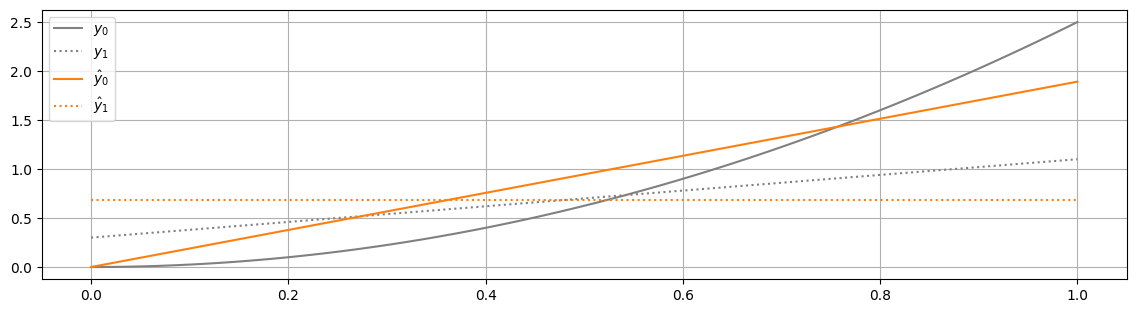

In [2]:
util.draw(w=None, figsize=figsize, model=1)

* The crossing point of the grey lines is where we should pick item 0 instead of 1
* The orange lines (trained model) miss it by a wide margin

## Not All is Lost

**However, we cas sidestep the issue by disergarding accuracy**

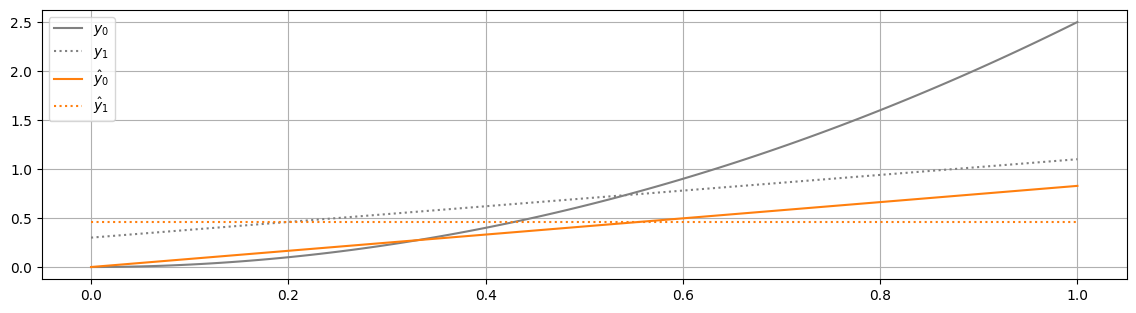

In [61]:
util.draw(w=0.91, figsize=figsize, model=1)

* If we focus on choosing $\theta$ to match the crossing point 
* ...We lead the optimizer to consistently making the correct choice

## The Main DFL Idea

**DFL attempts to achieve this by using a task-based loss at training time**

There's some consensus on this "holy grail" training problem:

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{(x, y) \sim P(X, Y)}[\text{regret}(\hat{y}, y)] \mid \hat{y} = f(x, \theta)\}
$$

Where in our setting we have:

$$
\text{regret}(\hat{y}, y) = y^T z^*(\hat{y}) - y^T z^*(y)
$$

* $z^*(\hat{y})$ is the best solution with the _estimated_ costs
* $z^*(y)$ is the best solution with the _true_ costs

Intuitively, we want to _loose as little as possible_ w.r.t. the best we could do

> **One of the main challenges in DFL is dealing with this loss**

## Knowing Regret

**To see this, let's push our example a little further**

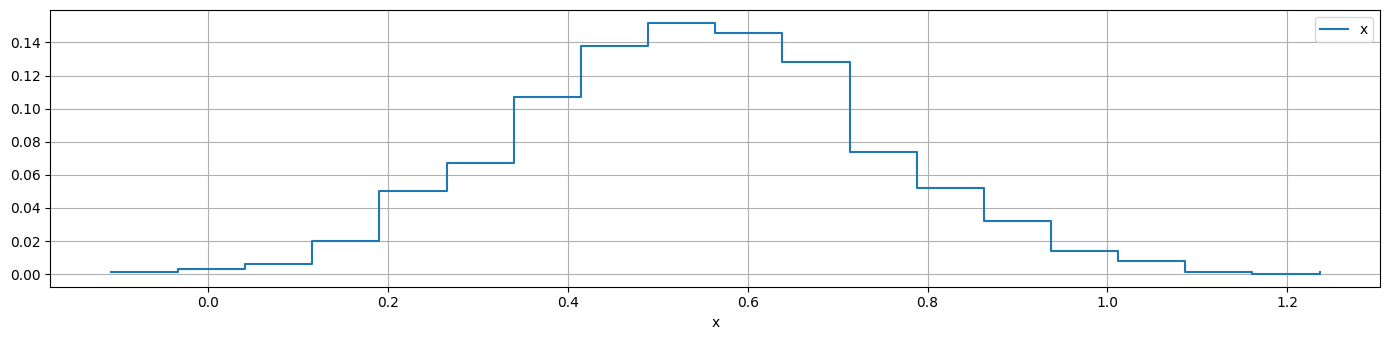

In [62]:
x = util.normal_sample_(mean=0.54, std=0.2, size=1000)
util.plot_histogram(x, figsize=figsize, label='x')

* Say we have access to a normally distributed collection of $x$ values
* ...And to the corresponding true values $y$

## Knowing Regret

**This is how regret looks like for a single example**

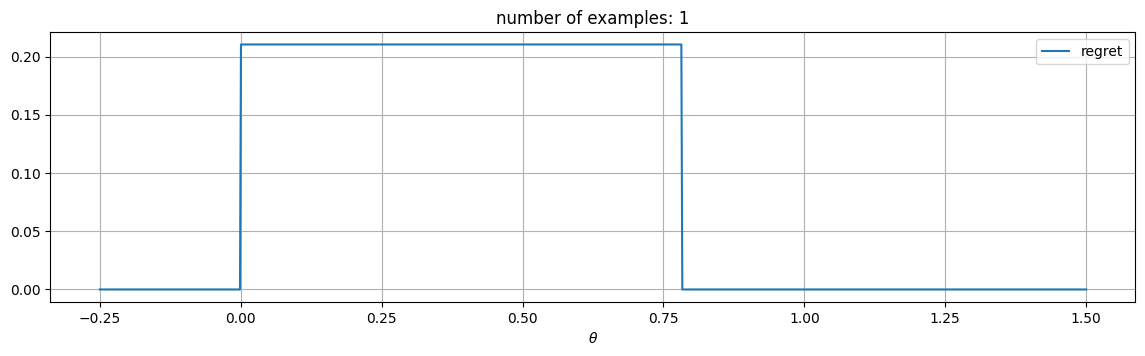

In [63]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=1, figsize=figsize)

* If $f(x, \theta)$ leads to the correct decision, the regret is 0
* Otherwise we have some non-null value

## Knowing Regret

**...And this is the same for a larger sample**

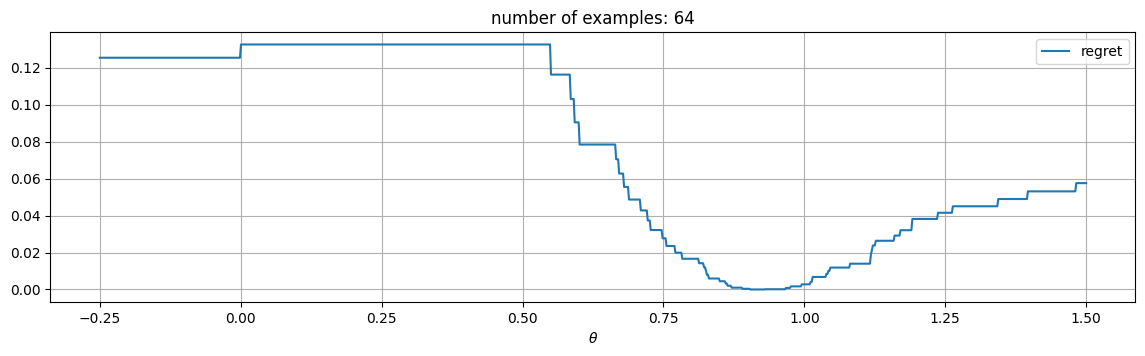

In [64]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=64, figsize=figsize)

* With linear optimization and finite samples the regret function is _piecewise constant_
* ...Which makes a direct use of gradient descent impossible

## SPO+ Loss

**A lot of research in the DFL field is about addressing this problem**

We will just recap the SPO+ loss from [1], which is (roughly) defined as:

$$
\text{spo}^+(\hat{y}, y) = \hat{y}_{spo}^T z^*(y) - \hat{y}_{spo}^T z^*(\hat{y}_{spo})
\quad
\text{ with: }
\quad
\hat{\bf y}_{spo} = 2 \hat{y} - y
$$

There are two main ideas here:

**The first it to see what happens with the _predicted_ (not the true) costs**

* We know $z^*(\hat{y}_{spo})$ is the optimal solution for $\hat{y}_{spo}$
* But we wish for $z^*(y)$ to be optimal instead
* Therefore if $\hat{y}_{spo}^T z^*(y) > \hat{y}_{spo}^T z^*(\hat{y}_{spo})$ we give a penalty

With this trick, a differentiable term (i.e. $\hat{y}_{spo}$) appears in the loss

<small><i>
[1] Elmachtoub, Adam N., and Paul Grigas. "Smart “predict, then optimize”." Management Science 68.1 (2022): 9-26.
</i></small>

## SPO+ Loss

**A lot of research in the DFL field is about addressing this problem**

We will just recap the SPO+ loss from [1], which is (roughly) defined as:

$$
\text{spo}^+(\hat{y}, y) = \hat{y}_{spo}^T z^*(y) - \hat{y}_{spo}^T z^*(\hat{y}_{spo})
\quad
\text{ with: }
\quad
\hat{\bf y}_{spo} = 2 \hat{y} - y
$$

**There are two main ideas here:**

The second, is to avoid using the estimates $y$ directly

* We rely instead on an altered cost vector, i.e. $\hat{y}_{spo}$
* Using $\hat{y}_{spo}$ directly would result in a _local minimum_ for $\hat{y} = 0$
* With $\hat{y}_{spo}$, the local minimum is in a location _that depends on $\hat{y}$

We'll try to visualize this phenomenon

<small><i>
[1] Elmachtoub, Adam N., and Paul Grigas. "Smart “predict, then optimize”." Management Science 68.1 (2022): 9-26.
</i></small>

## SPO+ Loss

**This is the SPO+ loss for a single example on our toy problem**

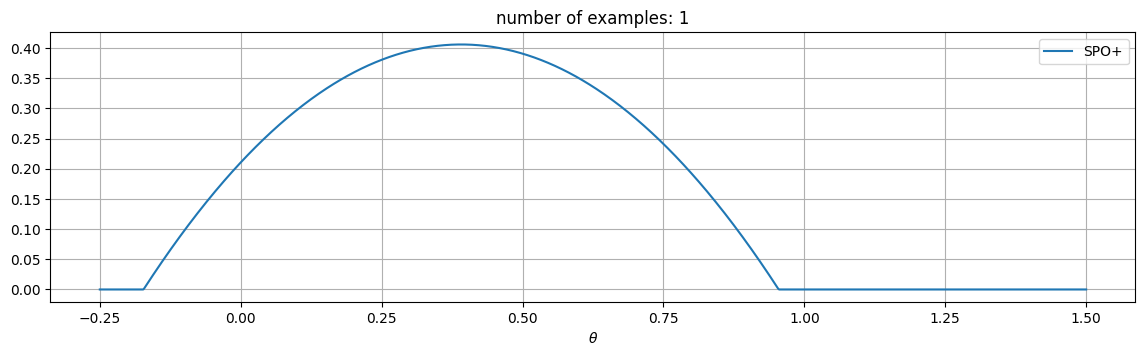

In [3]:
util.draw_loss_landscape(losses=[util.SPOPlusLoss()], model=1, seed=42, batch_size=1, figsize=figsize)

* As expected, there are two local minima

## SPO+ Loss

**This is the SPO+ loss for a _two examples_**

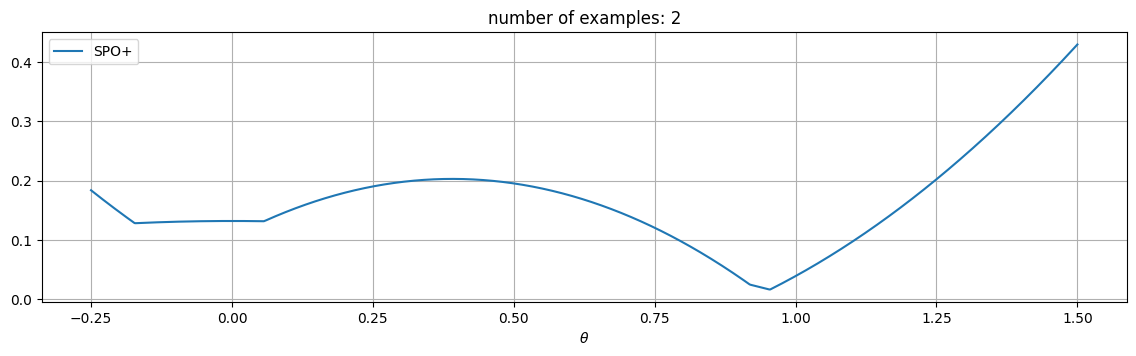

In [66]:
util.draw_loss_landscape(losses=[util.SPOPlusLoss()], model=1, seed=42, batch_size=2, figsize=figsize)

* The "good" local minima for both examples are roughly in the same place
* The "spurious" local minima fall in different position

## SPO+ Loss

**Over many example, the spurious local minima tend to cancel out**

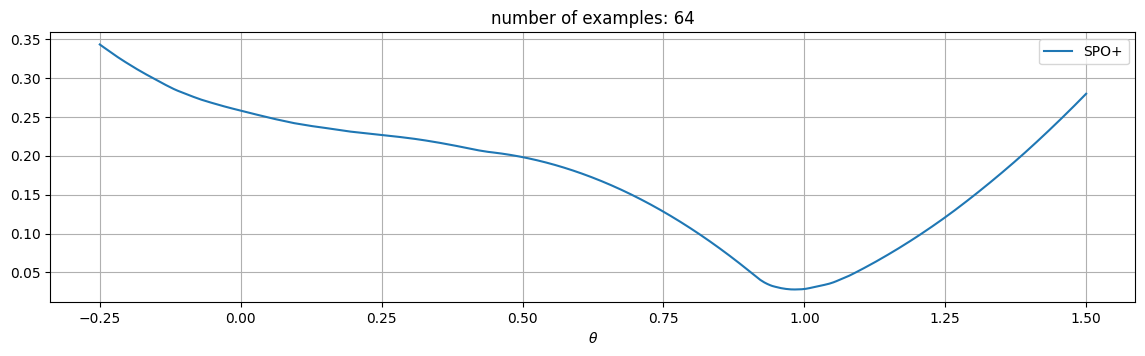

In [67]:
util.draw_loss_landscape(losses=[util.SPOPlusLoss()], model=1, seed=42, batch_size=64, figsize=figsize)

* This effect is _invaluable_ when training with gradient descent

## A (Sligthly) More Complex Example

**Let's see the approach in action on a second example**

We will consider this simple optimization problem:

$$
z^*(y) = \text{argmin} \{y^T z \mid v^T z \geq r, z \in \{0, 1\}^n \}
$$

* We need to decide which of a set of jobs to accept
* Accepting a job ($z_j = 1$) provides immediate value $v_j$
* The cost $y_j$ of the job is not known
* ...But it can be estimated based on available data

In [68]:
nitems, rel_req, seed = 20, 0.5, 42
prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)
display(prb)

ProductionProblem(values=[1.14981605 1.38028572 1.29279758 1.23946339 1.06240746 1.06239781
 1.02323344 1.34647046 1.240446   1.28322903 1.0082338  1.38796394
 1.33297706 1.08493564 1.07272999 1.0733618  1.1216969  1.20990257
 1.17277801 1.11649166], requirement=11.830809153591138)

## A (Sligthly) More Complex Example

**Next, we generate some training (and test) data**

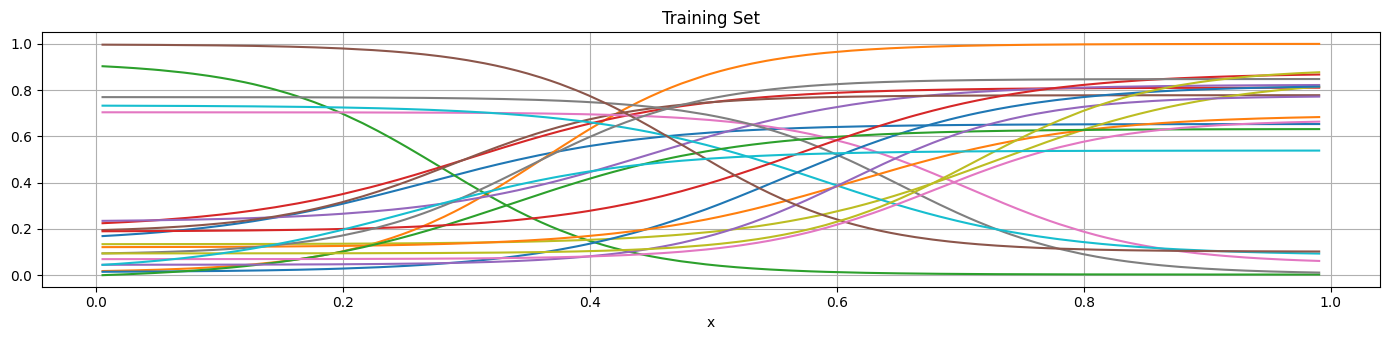

In [69]:
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=0, noise_type='normal', noise_scale_type='absolute')
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0, noise_type='normal', noise_scale_type='absolute')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set')

* We assume that costs can be estimated based on an scalar observable $x$
* The set of least expensive jobs changes considerably with $x$

## Prediction Focused Approach

**As a baseline, we'll consider a basic prediction-focused approach**

CPU times: user 8.28 s, sys: 283 ms, total: 8.56 s
Wall time: 6.94 s


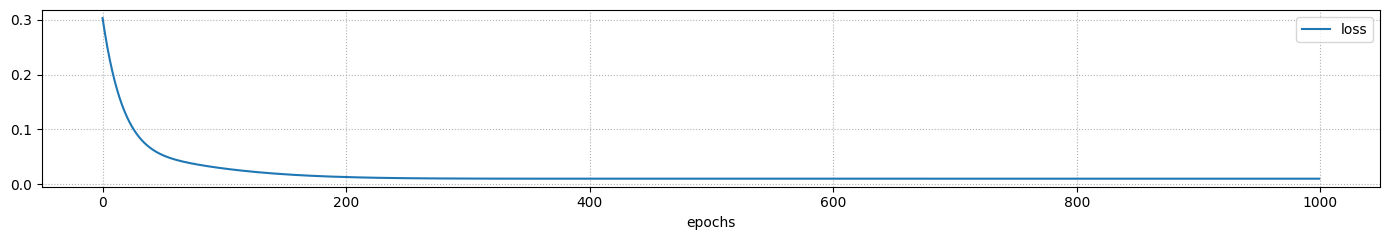

R2: 0.86, MAE: 0.086, RMSE: 0.10 (training)
R2: 0.86, MAE: 0.087, RMSE: 0.10 (test)


In [72]:
pfl = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='pfl_det', output_activation='linear')
%time history = util.train_nn_model(pfl, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(pfl, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl, data_ts.index.values, data_ts.values, label='test')

* The ML model is just a linear regressor, but it is decently accurate

## Prediction Focused Approach

**...But our true evaluation should be in terms of regret**

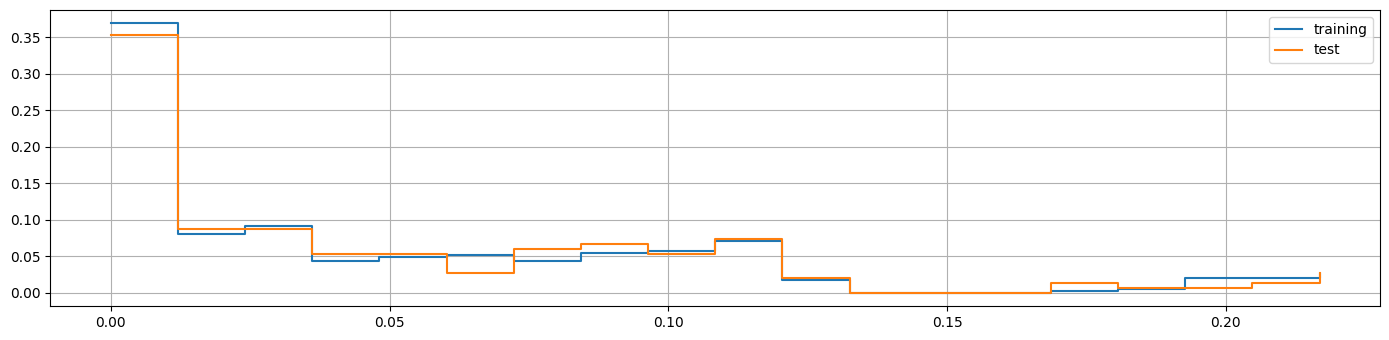

Mean: 0.052 (training), 0.052 (test)


In [73]:
r_tr = util.compute_regret(prb, pfl, data_tr.index.values, data_tr.values)
r_ts = util.compute_regret(prb, pfl, data_ts.index.values, data_ts.values)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)

* In this case, the average _relative_ regret is ~5%

## A Decision Focused Learning Approach

CPU times: user 3min 36s, sys: 13.6 s, total: 3min 49s
Wall time: 3min 49s


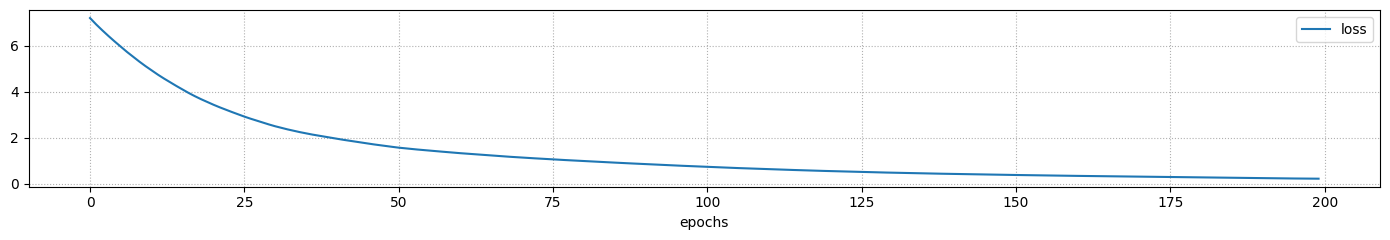

R2: -0.74, MAE: 0.25, RMSE: 0.32 (training)
R2: -0.72, MAE: 0.25, RMSE: 0.32 (test)


In [75]:
spo = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='spo', output_activation='linear', loss_type='spo')
%time history = util.train_dfl_model(spo, data_tr.index.values, data_tr.values, epochs=200, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(spo, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo, data_ts.index.values, data_ts.values, label='test')

In terms of accuracy, this is considerably worse

## Comparing Regrets

**But the regret is so much better!**

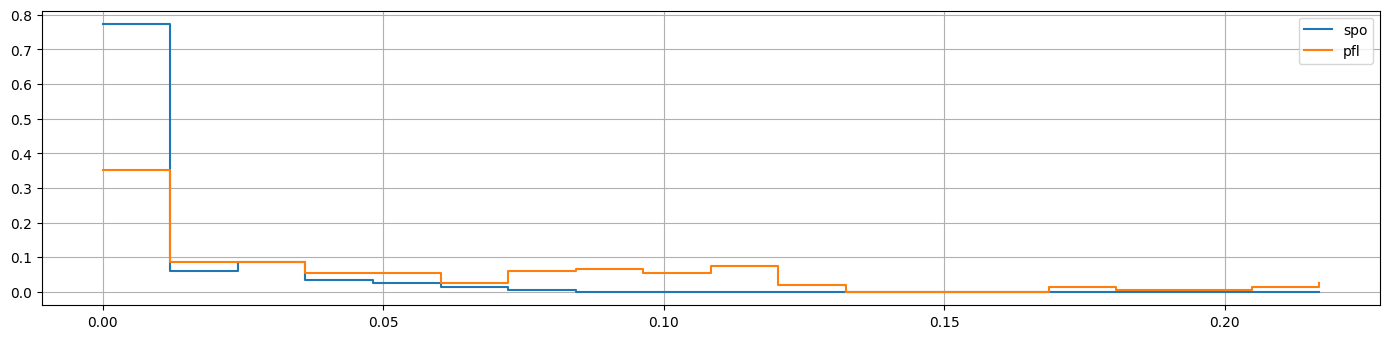

Mean: 0.008 (spo), 0.052 (pfl)


In [76]:
r_ts_spo = util.compute_regret(prb, spo, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_spo, figsize=figsize, label='spo', data2=r_ts, label2='pfl', print_mean=True)

This is the kind of result that attracted so much attention since [2]

<small><i>
[2] Donti, Priya, Brandon Amos, and J. Zico Kolter. "Task-based end-to-end model learning in stochastic optimization." Advances in neural information processing systems 30 (2017).
</i></small>